# Pulse Oximeter Simulation

### Libraries and Functions

#### Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
import secrets
from serial import Serial
from serial.tools.list_ports import comports

#### Signal simulation function

In [13]:
def simulate_signal(duration, fs, noise_level, square_wave_freq1, square_wave_freq2, sinusoidal_freq1, sinusoidal_freq2):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    
    # creation des ondes carree et sinusoidaux
    square_wave1 = signal.square(2 * np.pi * square_wave_freq1 * t)
    square_wave2 = signal.square(2 * np.pi * square_wave_freq2 * t)
    sinusoidal_wave1 = np.sin(2 * np.pi * sinusoidal_freq1 * t)
    sinusoidal_wave2 = np.sin(2 * np.pi * sinusoidal_freq2 * t)
    
    # Generee un tableau ("array") de bits aleatoire
    random_bytes = secrets.token_bytes(len(t))

    # Convertir les bits en NumPy array de valeur flottante entre 0 et 1
    random_array = np.frombuffer(random_bytes, dtype=np.uint8) / 255.0

    # Ajouter du bruit au signal
    signal_with_noise = (np.convolve(square_wave1, sinusoidal_wave1, mode='same') +
                        np.convolve(square_wave2, sinusoidal_wave2, mode='same')) + (2 * noise_level * random_array)
    
    return t, signal_with_noise, square_wave1, square_wave2, sinusoidal_wave1, sinusoidal_wave2

#### Signal Analysis Function

In [15]:
def analyze_signal(t, signal_with_noise, fs, square_wave_freq1, square_wave_freq2):
    # Compute the FFT
    fft_result = fft.fft(signal_with_noise)
    freqs = fft.fftfreq(len(fft_result), 1/fs)
    
    # trouver le pike representant le rythm cardiaque
    heart_rate_index = np.argmax(np.abs(fft_result))
    heart_rate = np.abs(freqs[heart_rate_index]) * 60
    
    # Deconvolution pour obtenir l'amplitude
    _, deconv1 = signal.deconvolve(signal_with_noise, signal.square(2 * np.pi * square_wave_freq1 * t))
    _, deconv2 = signal.deconvolve(signal_with_noise, signal.square(2 * np.pi * square_wave_freq2 * t))
    
    amplitude1 = np.max(deconv1)
    amplitude2 = np.max(deconv2)
    
    return heart_rate, amplitude1, amplitude2, deconv1, deconv2, freqs, fft_result

#### Oxygen Saturation Function

In [16]:
def calculate_oxygen_saturation(amplitude1, amplitude2):
    # Calcule du double ratio (R) du principe de Beer-Lambert
    R =  (amplitude1) / (amplitude2)
    
    # Estimation de la saturation de l'oxigene en utilisant la formule empirique
    SO2 = 34.74 * R**2 + 44.73 * R + 12.25
    
    return SO2

#### Plotting signals Function

In [17]:
def plot_signals(t, square_wave1, sinusoidal_wave1, square_wave2, sinusoidal_wave2, signal_with_noise):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 2, 1)
    plt.plot(t, square_wave1, label='Square Wave 1')
    plt.title('Square Wave 1')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(t, sinusoidal_wave1, label='Sinusoidal Wave 1')
    plt.title('Sinusoidal Wave 1')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(t, square_wave2, label='Square Wave 2')
    plt.title('Square Wave 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(t, sinusoidal_wave2, label='Sinusoidal Wave 2')
    plt.title('Sinusoidal Wave 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(t, signal_with_noise, label='Simulated Signal with Noise')
    plt.title('Simulated Signal with Noise')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Plotting FFTs Function

In [6]:
def plot_ffts(freqs, fft_result, square_wave1, sinusoidal_wave1):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(freqs, np.abs(fft_result), label='FFT of Signal with Noise')
    plt.title('FFT of Signal with Noise')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(freqs, np.abs(fft.fft(square_wave1)), label='FFT of Square Wave 1')
    plt.plot(freqs, np.abs(fft.fft(sinusoidal_wave1)), label='FFT of Sinusoidal Wave 1')
    plt.title('FFT of Square and Sinusoidal Waves')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Simulation

#### Simulation Parameters

In [33]:
duration = 10  # secondes
fs = 1000  # frequence d'echantillonage
noise_level = np.random.randint(12, 22) #parametre du bruit
# signal_with_noise = donnees
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
# Frequences
square_wave_freq1 = 3
square_wave_freq2 = 5

sinusoidal_freq1 = 1 /np.random.randint(1, 10) + 1 
sinusoidal_freq2 = sinusoidal_freq1

#### True Signal Simulation

In [30]:
t, signal_with_noise, square_wave1, square_wave2, sinusoidal_wave1, sinusoidal_wave2 = simulate_signal(
    duration, fs, noise_level, square_wave_freq1, square_wave_freq2, sinusoidal_freq1, sinusoidal_freq2)

#### Signal Analysis Simulation

In [37]:
heart_rate, amplitude1, amplitude2, deconv1, deconv2, freqs, fft_result = analyze_signal(
    t, signal_with_noise, fs, square_wave_freq1, square_wave_freq2
)

#### Simulation Results

In [ ]:
print(f"Heart Rate: {heart_rate :.2f} bpm")
print(f"Amplitude of Diode 1: {amplitude1:.2f}")
print(f"Amplitude of Diode 2: {amplitude2:.2f}")
SO2 = calculate_oxygen_saturation(amplitude2, amplitude1)
print(f"Oxygen Saturation: {SO2:.2f}%")

#### Simulation Plots

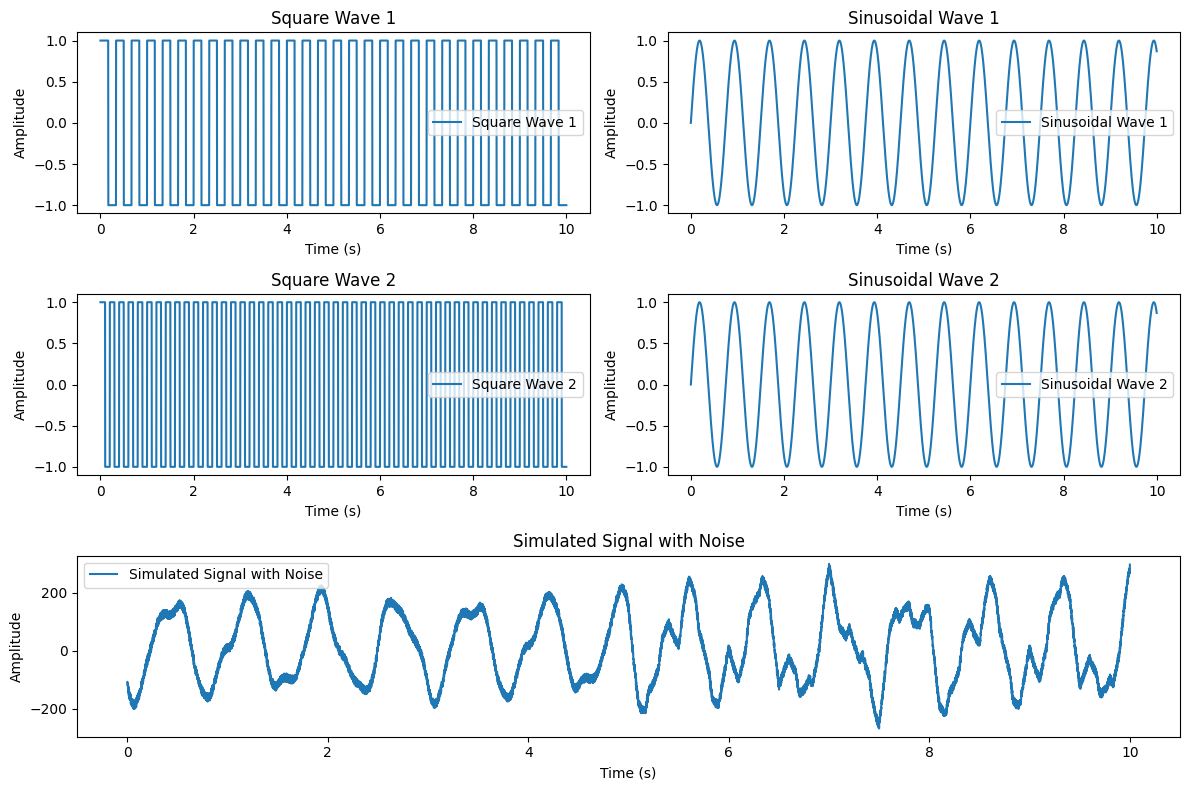

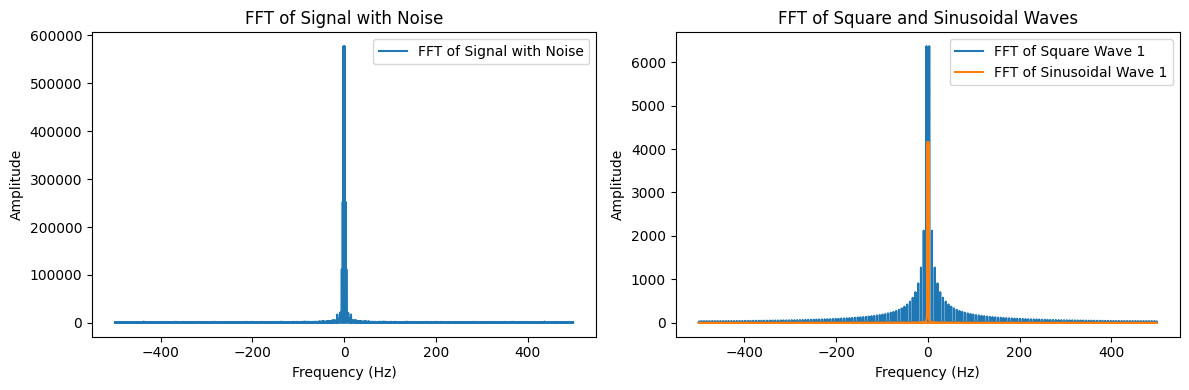

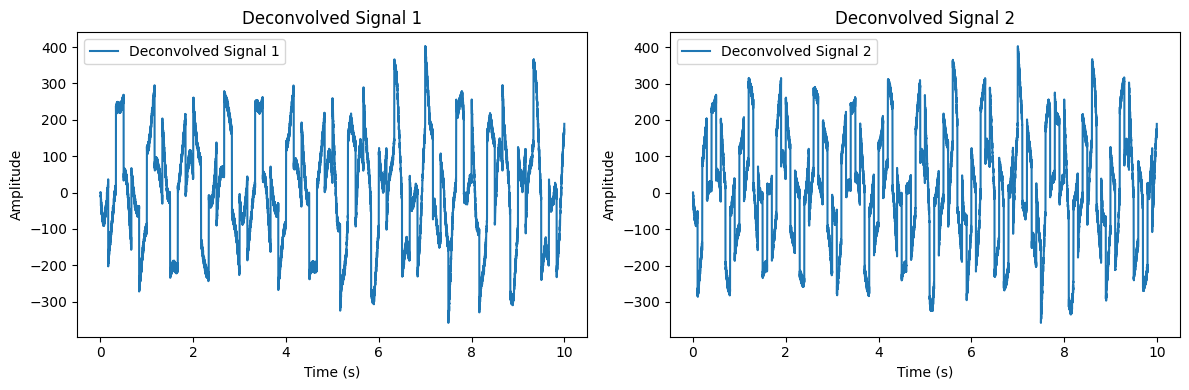

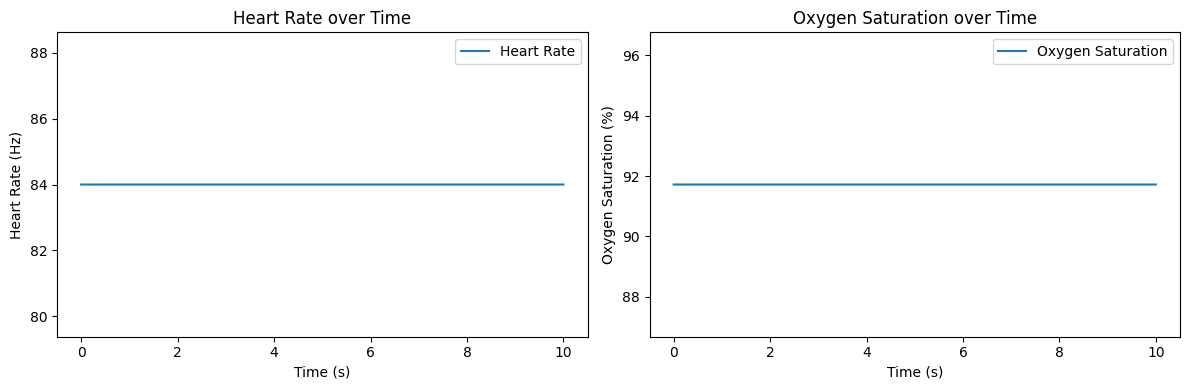

In [11]:
plot_signals(t, square_wave1, sinusoidal_wave1, square_wave2, sinusoidal_wave2, signal_with_noise)


plot_ffts(freqs, fft_result, square_wave1, sinusoidal_wave1)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(t, deconv1, label='Deconvolved Signal 1')
plt.title('Deconvolved Signal 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, deconv2, label='Deconvolved Signal 2')
plt.title('Deconvolved Signal 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(t, heart_rate*np.ones_like(t), label='Heart Rate')
plt.title('Heart Rate over Time')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (Hz)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, SO2*np.ones_like(t), label='Oxygen Saturation')
plt.title('Oxygen Saturation over Time')
plt.xlabel('Time (s)')
plt.ylabel('Oxygen Saturation (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Model Testing through Arduino

#### Arduino Nano Every interfacing

In [ ]:
ports = comports()
for i , p in enumerate( ports ) :
    print ( ' [ ' , i , ' ] ' , str (p) )
choix = int ( input ( '> ' ) )
port = ports [ choix ]

donnees = []

# print(dir(port))

with Serial(port.device) as com:
    for i in range(1000):
        while not com.in_waiting:
            continue
        raw_reading = com.readline()
        
        # Decode the bytes using the 'latin-1' encoding
        reading = raw_reading.decode('latin-1')
        
        # Filter out non-numeric characters
        numeric_chars = ''.join(char for char in reading if char.isdigit() or char in ['.', '-'])

        try:
            value = float(numeric_chars)
            print(value)
            donnees.append(value)
        except ValueError:
            print(f"Skipping non-numeric data: {reading}")